In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
import nltk
import pathlib
import textwrap
import requests
import json
requests.default_timeout = 120
import google.generativeai as genai
from IPython.display import display, Markdown
from google.colab import userdata
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Loading the Data

In [2]:
#loading data for training for models
training = pd.read_csv("/content/drive/MyDrive/TwitterSentimentClassificationData/training_dataset.csv",
                       encoding = "ISO-8859-1",
                       header = None,
                       names = ["Sentiment", "ids", "date", "flag", "user", "tweet"])

#Exploratory Data Analysis

In [3]:
#first 5 observations of training data
training.head(5)

,Sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print("Shape of Training Data: ",training.shape)    #printing number of rows and columns in training data

Shape of Training Data:  (1600000, 6)


0 represents negative sentiment and 4 represents positive sentiment. We will be changing 0 to negative and 4 to positive in both training and testing data.

In [5]:
training["Sentiment"] = np.where(training["Sentiment"] == 0, "Negative", "Positive")    #converting 0 to Negative and 4 to Positive in training data

In [6]:
#First 5 observations of training data after changing values of Sentiment Column
training.head(5)

,Sentiment,ids,date,flag,user,tweet
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


##Count of data samples for Positive and Negative Sentiments.

In [7]:
#separating positive sentiment tweets and negative sentiment tweets
positives = training[training['Sentiment'] == 'Positive']
negatives = training[training['Sentiment'] == 'Negative']

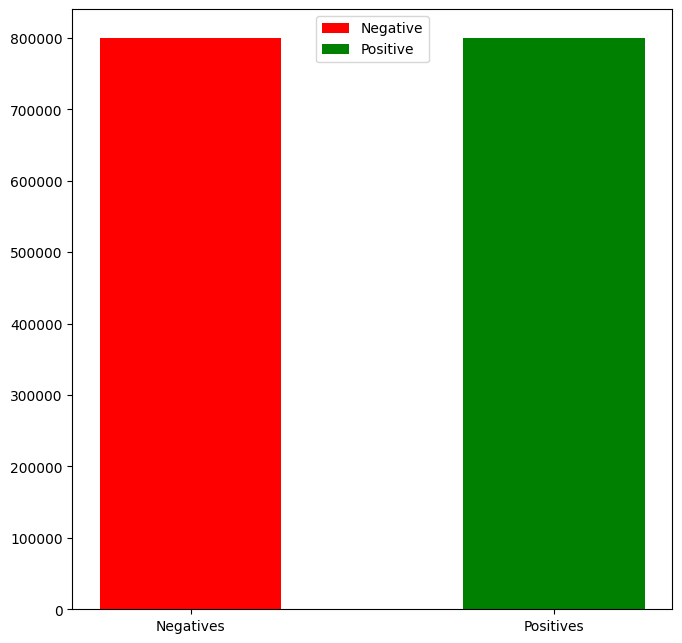

In [8]:
#plotting a bar graph of count of rows for positive tweets and negative tweets.
fig = plt.figure(figsize = (6, 6)) #adding figure
ax = fig.add_axes([0, 0, 1, 1])  #adding axis to our figure
ax.bar("Negatives", len(negatives), color = "Red", width = 0.5, label = "Negative")   #bar chart for negative sentiment tweets
ax.bar("Positives", len(positives), color = "Green", width = 0.5, label = "Positive") #bar chart for positive sentiment tweets
ax.legend(loc = "upper center")     #plotting the legend for bar chart
plt.show()

We 8,00,000 tweets which are labels with positive sentiment and 8,00,000 with negative sentiment so our dataset is **balanced**.

##Count of words in positive and negative sentiments.Distribution plot for count of words in both classes.

In [9]:
#count of words in positive sentiments
count_words_positive = positives['tweet'].str.split().apply(lambda w: len(w))     #calculating count of words in positive sentiment tweets

print("Count of Words in each tweet for Positive Sentiment: \n",count_words_positive)   #printing count of words in positive sentiment tweets

Count of Words in each tweet for Positive Sentiment: 
 800000      8
800001     14
800002     27
800003     21
800004      7
           ..
1599995    11
1599996    11
1599997    11
1599998    12
1599999     5
Name: tweet, Length: 800000, dtype: int64


In [10]:
#count of words in negative sentiments
count_words_negative = negatives['tweet'].str.split().apply(lambda w: len(w))     #calculating count of words in negative sentiment tweets

print("Count of Words in each tweet for Negative Sentiment: \n",count_words_negative)   #printing count of words in negative sentiment tweets

Count of Words in each tweet for Negative Sentiment: 
 0         19
1         21
2         18
3         10
4         21
          ..
799995    10
799996     3
799997     6
799998    17
799999    15
Name: tweet, Length: 800000, dtype: int64


In [11]:
#defining a function to plot distribution plot for various counts
def plot_distplot(countPositive, countNegative, titlePositive, titleNegative):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))     #defining a figure and two subplots within it for positive and negative tweets
  sns.distplot(countPositive, ax = ax1, color = "Green")      #plotting distribution plot of counts of for positive tweets
  ax1.set_title(titlePositive)
  sns.distplot(countNegative, ax = ax2, color = "Red")        #plotting distribution plot of counts of for negative tweets
  ax2.set_title(titleNegative)
  plt.show()

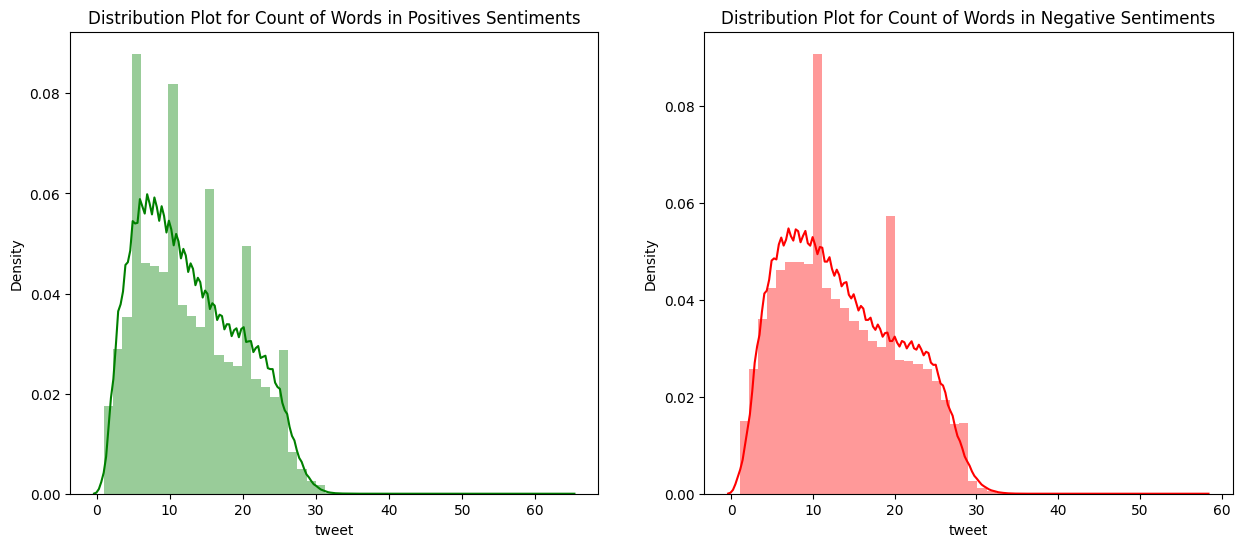

In [12]:
#distribution plot of count of words in positive and negative sentiments
plot_distplot(count_words_positive, count_words_negative, "Distribution Plot for Count of Words in Positives Sentiments", "Distribution Plot for Count of Words in Negative Sentiments")

##Count of Punctuations

In [13]:
#counting number of punctuations in positive and negative tweets
count_punctuations_postives = positives['tweet'].apply(lambda w: len([p for p in str(w) if p in string.punctuation]))
count_punctuations_negatives = negatives['tweet'].apply(lambda w: len([p for p in str(w) if p in string.punctuation]))

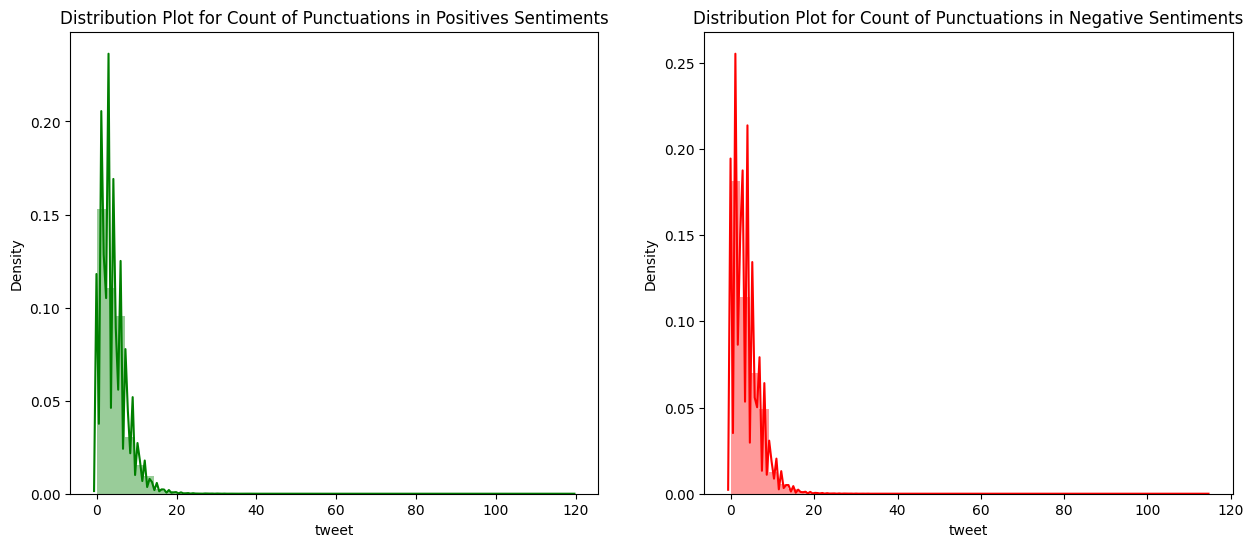

In [14]:
plot_distplot(count_punctuations_postives, count_punctuations_negatives, "Distribution Plot for Count of Punctuations in Positives Sentiments", "Distribution Plot for Count of Punctuations in Negative Sentiments")

##Count of Stop Words

In [15]:
stops=set(stopwords.words('english'))   #defining a set of stopwords using stopwords from nltk library


#count number of stop words in postive and negative sentiment tweets
count_stop_positives = positives['tweet'].apply(lambda w: len([s for s in str(w).split() if s in stops]))
count_stop_negatives = negatives['tweet'].apply(lambda w: len([s for s in str(w).split() if s in stops]))

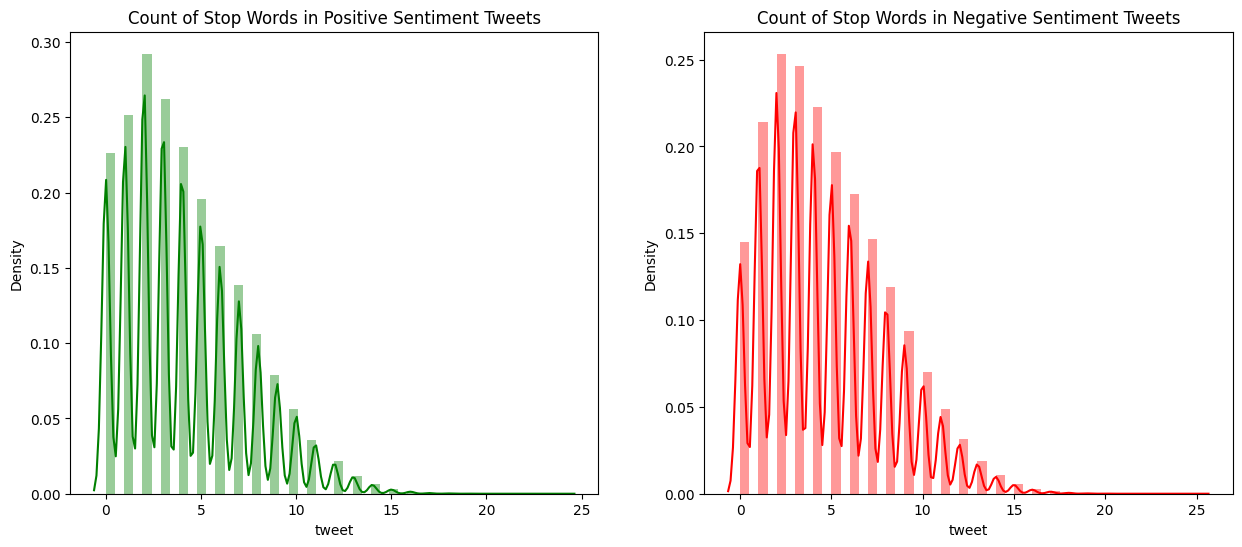

In [16]:
#plotting count stop words in positive and negative sentiments
plot_distplot(count_stop_positives, count_stop_negatives, "Count of Stop Words in Positive Sentiment Tweets", "Count of Stop Words in Negative Sentiment Tweets")

##Count of URLs

In [17]:
#counting number of URLs in positive and negative tweets
count_url_positives = positives['tweet'].apply(lambda w: len([s for s in str(w).lower().split() if 'http' in s or 'https' in s]))
count_url_negatives = negatives['tweet'].apply(lambda w: len([s for s in str(w).lower().split() if 'http' in s or 'https' in s]))

URL count Distionary for Positive Tweets:  {0: 753765, 1: 45295, 2: 841, 3: 79, 4: 13, 5: 7}
URL count Distionary for Negative Tweets:  {0: 775987, 1: 23653, 2: 336, 3: 20, 4: 4}


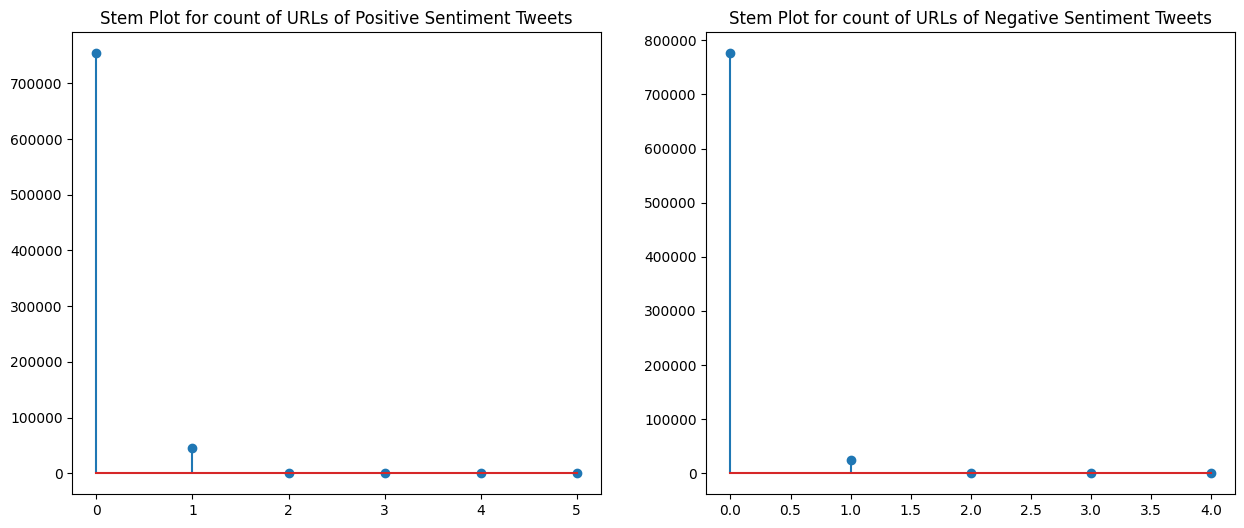

In [18]:
pos = count_url_positives.value_counts().to_dict()    #creating a dictionary of count of tweets with total urls for positive tweets
neg = count_url_negatives.value_counts().to_dict()    #creating a dictionary of count of tweets with total urls for negative tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6)) #figure with 2 subplots

#stem chart for positive tweets
count = list(pos.keys())    #list of keys from pos dicionary
values = list(pos.values())   #list repestive to key from dictionary
ax1.stem(count, values)   #plotting the stem plot for URL count of Positive Sentiment Tweets
ax1.set_title("Stem Plot for count of URLs of Positive Sentiment Tweets")
print("URL count Distionary for Positive Tweets: ", pos)    #printing the pos dictionary


#stem chart for negative tweets
count = list(neg.keys())      #list of keys from neg dicionary
values = list(neg.values())   #list repestive to key from dictionary
ax2.stem(count, values)   #plotting the stem plot for URL count of Negative Sentiment Tweets
ax2.set_title("Stem Plot for count of URLs of Negative Sentiment Tweets")
print("URL count Distionary for Negative Tweets: ", neg)    #printing the neg dictionary


plt.show()

From the plots of counts we can see that each tweet contains lots of Stop Words, Punctuations and few tweets also contain URLs. During Data cleaning we need to remove all of this.

In [19]:
#definfing a function to plot word cloud
def wordcloud(sentiment):
  stop_words = set(STOPWORDS)
  comment = ''
  for tweet in sentiment.tweet:
    t = str(tweet)

    tokens = t.split()

    for i in range(len(tokens)):
      tokens[i] = tokens[i].lower()

    comment += " ".join(tokens)+ " "

  word_cloud = WordCloud(width = 800,
                        height = 800,
                        background_color = 'white',
                        stopwords = stop_words,
                        min_font_size = 10).generate(comment)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(word_cloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

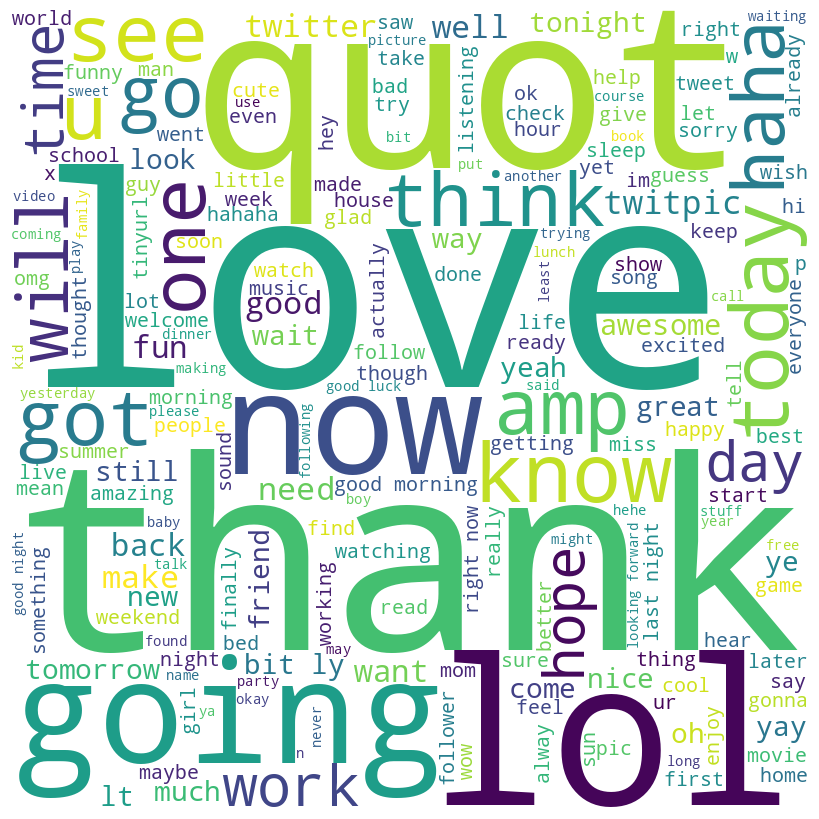

In [20]:
#wordcloud of positives after cleaning data
#separating positive sentiment tweets and negative sentiment tweets
positives = training[training['Sentiment'] == 'Positive']
negatives = training[training['Sentiment'] == 'Negative']

wordcloud(positives)    #wordcloud for positive sentiment tweets

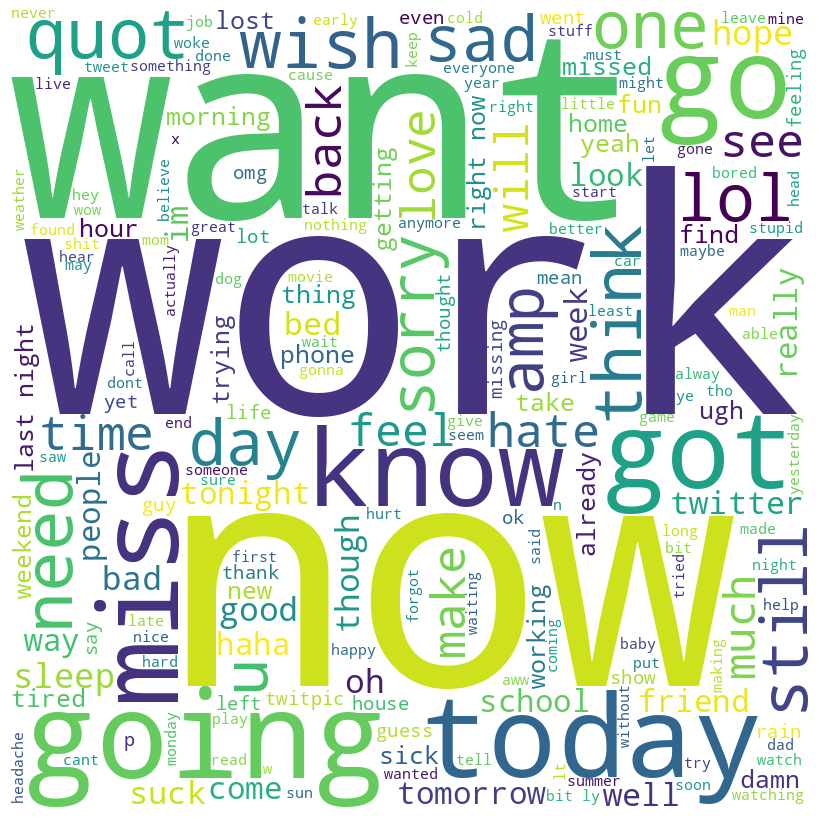

In [21]:
wordcloud(negatives)    #wordcloud for negative sentiment tweets

#Data Cleaning

##Dropping columns

As we want to classify sentiment of tweets as positive or negative, information regarding ids, date, flag and user is not relevant for us so we will be dropping them.

In [22]:
#dropping unnecessary columns from training and testing sets
training = training.drop(['ids', 'date', 'flag', 'user'], axis = 1)

training

,Sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...


##Converting Tweets to lowercase

In [23]:
#convering all tweets to lowercase
training['tweet'] = training['tweet'].str.lower()

print("Training Dataset after converting to Lowercase: \n")
training

Training Dataset after converting to Lowercase: 



,Sentiment,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,Negative,is upset that he can't update his facebook by ...
2,Negative,@kenichan i dived many times for the ball. man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,just woke up. having no school is the best fee...
1599996,Positive,thewdb.com - very cool to hear old walt interv...
1599997,Positive,are you ready for your mojo makeover? ask me f...
1599998,Positive,happy 38th birthday to my boo of alll time!!! ...


##Removing Punctuations

In [24]:
#function to remove punctuations
def clean_punctuations(string1):
  temp = string1.maketrans("", "", string.punctuation)
  return string1.translate(temp)

training['tweet'] = training['tweet'].apply(lambda w: clean_punctuations(w))

print("Training Dataset after removing punctuations: \n")
training

Training Dataset after removing punctuations: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats a b...
1,Negative,is upset that he cant update his facebook by t...
2,Negative,kenichan i dived many times for the ball manag...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,nationwideclass no its not behaving at all im ...
...,...,...
1599995,Positive,just woke up having no school is the best feel...
1599996,Positive,thewdbcom very cool to hear old walt intervie...
1599997,Positive,are you ready for your mojo makeover ask me fo...
1599998,Positive,happy 38th birthday to my boo of alll time tup...


##Removing Stop Words

In [25]:
#function to remove stop words
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stops])
training['tweet'] = training['tweet'].apply(lambda text: cleaning_stopwords(text))
print("Training Dataset after removing stopwords: \n")
training

Training Dataset after removing stopwords: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing URLs

In [26]:
#funtion to remove URLs from dataset
def clean_url(string1):
  string1 = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string1, flags=re.MULTILINE)
  return string1

training['tweet'] = training['tweet'].apply(lambda w: clean_url(w))
print("Training Dataset after removing URLs: \n")
training

Training Dataset after removing URLs: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing Emojis

In [27]:
#function to remove emojis
def remove_emoji(string):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  string = emoji_pattern.sub(r'', string)
  return string

training['tweet'] = training['tweet'].apply(lambda w: remove_emoji(w))
print("Training Dataset after removing Emojis: \n")
training

Training Dataset after removing Emojis: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccom2y1zl awww thats bumm...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy 38th birthday boo alll time tupac amaru ...


##Removing Numeric Values

In [28]:
#function to remove numeric values
def remove_numeric(string):
  return re.sub('[0-9]+', '', string)

training['tweet'] = training['tweet'].apply(lambda w: remove_numeric(w))
print("Training Dataset after removing Numeric Values: \n")
training

Training Dataset after removing Numeric Values: 



,Sentiment,tweet
0,Negative,switchfoot httptwitpiccomyzl awww thats bummer...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,kenichan dived many times ball managed save r...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
...,...,...
1599995,Positive,woke school best feeling ever
1599996,Positive,thewdbcom cool hear old walt interviews â« ht...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy th birthday boo alll time tupac amaru sh...


#Splitting the Dataset

In [29]:
#Spliting the training dataset into training and testing sets
totalRows = len(training)
testSize = int(totalRows * 0.30)

testSet = training.sample(testSize)
trainSet = training.drop(testSet.index)

In [30]:
#Training set
trainSet

,Sentiment,tweet
0,Negative,switchfoot httptwitpiccomyzl awww thats bummer...
1,Negative,upset cant update facebook texting might cry r...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving im mad cant see
5,Negative,kwesidei whole crew
...,...,...
1599993,Positive,scoobygritboys
1599994,Positive,cliffforster yeah work better waiting end wond...
1599997,Positive,ready mojo makeover ask details
1599998,Positive,happy th birthday boo alll time tupac amaru sh...


In [31]:
#Test Set
testSet

,Sentiment,tweet
279845,Negative,monday surely b long week back work wednesday
723802,Negative,back freedom tired pooo
284461,Negative,hmmm turning mobil stations town circle ks goo...
1348765,Positive,starjosh looks dead good eurgh jealous prettyn...
77033,Negative,reason app reviews showing itunes
...,...,...
53734,Negative,waittoexplode tooooo
1224322,Positive,staring door work listening mars volta wishing...
1563921,Positive,im going apple store screaming quotyou congrat...
1597706,Positive,woot mvp lead year today year


#Sentiment Prediction Using Gemini API

##Setting Up Gemini API

In [79]:
!pip install -q -U google-generativeai

In [80]:
#function to convert tweets to markdown
def to_markdown(tweet):
  tweet = tweet.replace(".", "  *")
  return Markdown(textwrap.indent(tweet, '> ', predicate = lambda _: True))

#Google Gemini API Key
apiKey = userdata.get("GoogleGemini")
genai.configure(api_key = apiKey)

In [81]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


##Loading the model

In [82]:
#loading the gemini-pro model for our use
model = genai.GenerativeModel('gemini-1.0-pro')

#Checking if model is working by giving it a simple prompt
answer = model.generate_content("What is Natural Language Processing") #The string is our prompt we will give to model to check
to_markdown(answer.text)

> **Natural Language Processing (NLP)** is a subfield of artificial intelligence (AI) that deals with the interaction between computers and human (natural) languages  * NLP allows computers to understand, interpret, and generate human language in a meaningful way  *
> 
> **Key Aspects of NLP:**
> 
> * **Natural Language Understanding (NLU):** Analyzing and comprehending the meaning of human language input  *
> * **Natural Language Generation (NLG):** Producing human-like text or speech from structured data  *
> * **Machine Translation:** Translating text from one natural language to another  *
> * **Text Summarization:** Condensing a large body of text into a concise summary  *
> * **Sentiment Analysis:** Detecting the emotional sentiment expressed in text  *
> 
> **Applications of NLP:**
> 
> NLP has numerous applications in various industries, including:
> 
> * **Chatbots and Virtual Assistants:** Enabling computers to interact with humans through natural language conversations  *
> * **Search Engines:** Improving search results by understanding the meaning of search queries  *
> * **Machine Translation:** Automatically translating documents, websites, and conversations  *
> * **Text Analytics and Business Intelligence:** Identifying trends and insights from unstructured text data  *
> * **Social Media Analysis:** Understanding public sentiment and extracting valuable information from social media platforms  *
> * **Healthcare:** Assisting medical professionals with diagnosis, treatment planning, and patient communication  *
> * **Education:** Providing personalized learning experiences and language learning support  *
> 
> **Challenges in NLP:**
> 
> * **Ambiguity and Context:** Natural language is often ambiguous and heavily dependent on context, making it difficult for computers to accurately interpret meaning  *
> * **Vocabulary and Semantics:** The vast vocabulary and complex semantics of natural languages pose challenges for NLP systems  *
> * **Syntax and Grammar:** The rules and patterns of language syntax and grammar can be difficult for computers to master  *
> * **Real-Time Processing:** Applications require NLP systems to process language in real-time, which can be computationally demanding  *
> 
> **Advancements in NLP:**
> 
> Recent years have seen significant advancements in NLP, driven by:
> 
> * **Large Language Models (LLMs):** Generative AI models with massive datasets that can understand and generate human-like language  *
> * **Transfer Learning:** Using pre-trained NLP models to accelerate learning on specific tasks  *
> * **Cloud Computing:** Providing the computational power and infrastructure for large-scale NLP applications  *
> 
> NLP continues to play a vital role in bridging the gap between human communication and computer systems  * It has the potential to revolutionize numerous industries and enhance our daily interactions with technology  *

As we can see the model is giving us an answer to out prompt.

##Making Predictions with Gemini Model

In [83]:
#Sampling 500 tweets to give to gemini model for prediction
tempTrainSet = trainSet.sample(500)
tempTrainSet["Sentiment"] = np.where(tempTrainSet["Sentiment"] == 'Positive', 1, 0)


tempTrainSet['Predicted Sentiment'] = ''    #creating an empty column to store the predicted sentiments by gemini
tempTrainSet

,Sentiment,tweet,Predicted Sentiment
1501000,1,bridgetayers havent actually tried though woul...,
504514,0,second week without coffee good coming gal use...,
801382,1,maikeru np mean problem marriott world worked ...,
725716,0,random moments sadness httpplurkcompl,
884446,1,sherrieshepherd fortunately still awake austra...,
...,...,...,...
544620,0,english exam,
815817,1,head photograph umoja expo amp festival fiu bi...,
1595244,1,peterlombardi days always excellent get go home,
1181622,1,alexrk haha yes true miss alex ahhh need come ...,


In [84]:
#As we have close to 11.5 Lakh tweets we can't process all of this in one go so we will supply in batches
batches = []
batchSize = 50

#creaing batches
for i in range(0, len(tempTrainSet), batchSize):
  batches.append(tempTrainSet[i : i + batchSize])

In [85]:
#function to batch process
def batchprocess(batch, current_batch, total_batch):
  """
  This function is used to process our whole twitter data in batches.
  First we convert from dataframes to JSON.
  Then we pass it to gemini model along with a prompt.
  """

  print("Current Batch: ", current_batch + 1)

  jsonData = batch[['tweet', 'Predicted Sentiment']].to_json(orient = 'records')

  prompt = f"""You are an expert linguist, who is good at classifying twitter tweets sentiments into Positive/Negative labels.
  Help me classify Tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'Predicted Sentiment' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {jsonData}
  ```
  """

  answer = model.generate_content(prompt)
  return answer

#processing the all tweets in batches
answers = []
for i in range(len(batches)):
  answers.append(batchprocess(batches[i], i, len(batches)))

Current Batch:  1
Current Batch:  2
Current Batch:  3
Current Batch:  4
Current Batch:  5
Current Batch:  6
Current Batch:  7
Current Batch:  8
Current Batch:  9
Current Batch:  10


In [86]:
#getting answers in a dataframe
results = pd.DataFrame()

for answer in answers:
  #cleaning the json data
  jsonData = answer.text.strip("`")

  #load the data into dataframe
  data = json.loads(jsonData)
  temp = pd.DataFrame(data)

  results = pd.concat([results, temp], ignore_index = True)

results

,tweet,Predicted Sentiment
0,bridgetayers havent actually tried though woul...,0
1,second week without coffee good coming gal use...,1
2,maikeru np mean problem marriott world worked ...,1
3,random moments sadness httpplurkcompl,0
4,sherrieshepherd fortunately still awake austra...,1
...,...,...
495,english exam,0
496,head photograph umoja expo amp festival fiu bi...,1
497,peterlombardi days always excellent get go home,1
498,alexrk haha yes true miss alex ahhh need come ...,1


In [88]:
tempTrainSet['Predicted Sentiment'] = results['Predicted Sentiment'].values
tempTrainSet

,Sentiment,tweet,Predicted Sentiment
1501000,1,bridgetayers havent actually tried though woul...,0
504514,0,second week without coffee good coming gal use...,1
801382,1,maikeru np mean problem marriott world worked ...,1
725716,0,random moments sadness httpplurkcompl,0
884446,1,sherrieshepherd fortunately still awake austra...,1
...,...,...,...
544620,0,english exam,0
815817,1,head photograph umoja expo amp festival fiu bi...,1
1595244,1,peterlombardi days always excellent get go home,1
1181622,1,alexrk haha yes true miss alex ahhh need come ...,1


In [89]:
#plotting confusion metrics and getting accuracy
yTrue = tempTrainSet['Sentiment']
yPred = tempTrainSet['Predicted Sentiment']

confusion_matrix(yTrue, yPred)

array([[193,  47],
       [ 44, 216]])

In [90]:
print("Accuracy Score: ", accuracy_score(yTrue, yPred))

Accuracy Score:  0.818
